In [1]:
import os
import tarfile

import numpy as np
import pandas as pd
from scipy.stats import randint
from six.moves import urllib

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor

import mlflow
import mlflow.sklearn
#import mlflow.version
import matplotlib

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
remote_server_uri = "http://localhost:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)  # or set the MLFLOW_TRACKING_URI in the env

In [3]:
mlflow.tracking.get_tracking_uri()

'http://localhost:5000'

In [4]:
exp_name = "housing_ml"
mlflow.set_experiment(exp_name)

2023/02/28 19:46:05 INFO mlflow.tracking.fluent: Experiment with name 'housing_ml' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlruns/266915261347352009', creation_time=1677593765392, experiment_id='266915261347352009', last_update_time=1677593765392, lifecycle_stage='active', name='housing_ml', tags={}>

In [5]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [6]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

In [7]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


fetch_housing_data()
housing = load_housing_data()

In [8]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [9]:
param_distribs = {
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=8),
}

def model(housing,strat_train_set,strat_test_set):
    with mlflow.start_run():
        mlflow.log_param("parent", "yes")
        
        with mlflow.start_run(run_name='CHILD_RUN0', nested=True) as child_run:
                            
            train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
            compare_props = pd.DataFrame(
                {
                    "Overall": income_cat_proportions(housing),
                    "Stratified": income_cat_proportions(strat_test_set),
                    "Random": income_cat_proportions(test_set),
                }
            ).sort_index()
            compare_props["Rand. %error"] = (
                100 * compare_props["Random"] / compare_props["Overall"] - 100
            )
            compare_props["Strat. %error"] = (
                100 * compare_props["Stratified"] / compare_props["Overall"] - 100
            )
            for set_ in (strat_train_set, strat_test_set):
                set_.drop("income_cat", axis=1, inplace=True)

            housing = strat_train_set.copy()
            housing.plot(kind="scatter", x="longitude", y="latitude")
            housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

            corr_matrix = housing.corr()
            corr_matrix["median_house_value"].sort_values(ascending=False)
            housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
            housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
            housing["population_per_household"] = housing["population"] / housing["households"]

            housing = strat_train_set.drop(
                "median_house_value", axis=1
            )  # drop labels for training set
            housing_labels = strat_train_set["median_house_value"].copy()

            imputer = SimpleImputer(strategy="median")

            housing_num = housing.drop("ocean_proximity", axis=1)

            imputer.fit(housing_num)
            X = imputer.transform(housing_num)

            housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
            housing_tr["rooms_per_household"] = housing_tr["total_rooms"] / housing_tr["households"]
            housing_tr["bedrooms_per_room"] = (
                housing_tr["total_bedrooms"] / housing_tr["total_rooms"]
            )
            housing_tr["population_per_household"] = (
                housing_tr["population"] / housing_tr["households"]
            )

            housing_cat = housing[["ocean_proximity"]]
            housing_prepared = housing_tr.join(pd.get_dummies(housing_cat, drop_first=True))
            
            
            X_test = strat_test_set.drop("median_house_value", axis=1)
            y_test = strat_test_set["median_house_value"].copy()
            X_test_num = X_test.drop("ocean_proximity", axis=1)
            X_test_prepared = imputer.transform(X_test_num)
            X_test_prepared = pd.DataFrame(
                X_test_prepared, columns=X_test_num.columns, index=X_test.index
            )
            X_test_prepared["rooms_per_household"] = (
                X_test_prepared["total_rooms"] / X_test_prepared["households"]
            )
            X_test_prepared["bedrooms_per_room"] = (
                X_test_prepared["total_bedrooms"] / X_test_prepared["total_rooms"]
            )
            X_test_prepared["population_per_household"] = (
                X_test_prepared["population"] / X_test_prepared["households"]
            )

            X_test_cat = X_test[["ocean_proximity"]]
            X_test_prepared = X_test_prepared.join(pd.get_dummies(X_test_cat, drop_first=True))
        
        
        with mlflow.start_run(run_name='CHILD_RUN1', nested=True) as child_run:
            mlflow.log_param("child", "yes")
            forest_reg = RandomForestRegressor(random_state=42)
            forest_reg.fit(housing_prepared, housing_labels)
            rnd_search = RandomizedSearchCV(
            forest_reg,
            param_distributions=param_distribs,
            n_iter=10, 
            cv=5,
            scoring="neg_mean_squared_error",random_state=42, )
            rnd_search.fit(housing_prepared, housing_labels)
            cvres = rnd_search.cv_results_
  #          for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  #             print(np.sqrt(-mean_score), params) 
            predrf=rnd_search.predict(X_test_prepared)
            (rmse,mae,r2)=eval_metrics(y_test,predrf)
            mlflow.log_metric(key="rmse", value=rmse)
            mlflow.log_metrics({"mae": mae, "r2": r2})
 #           mlflow.log_metric(key="mean_score", value=-mean_score)
            mlflow.sklearn.log_model(rnd_search, "model")
        with mlflow.start_run(run_name='CHILD_RUN2', nested=True) as child_run:
            mlflow.log_param("child", "yes")
            lin_reg = LinearRegression()
            lin_reg.fit(housing_prepared, housing_labels)
            predlr= lin_reg.predict(X_test_prepared)
            (rmse,mae,r2)=eval_metrics(y_test, predlr)
            mlflow.log_metric(key="rmse", value=rmse)
            mlflow.log_metrics({"mae": mae, "r2": r2})
            mlflow.sklearn.log_model(lin_reg, "model")

           
        with mlflow.start_run(run_name='CHILD_RUN3', nested=True) as child_run:
            mlflow.log_param("child", "yes")
            dtr = DecisionTreeRegressor()
            dtr.fit(housing_prepared, housing_labels)
            preddtr = dtr.predict(X_test_prepared)
            (rmse,mae,r2) = eval_metrics(y_test, preddtr)
            mlflow.log_metric(key="rmse", value=rmse)
            mlflow.log_metrics({"mae": mae, "r2": r2})
            mlflow.sklearn.log_model(dtr, "model")
           

/tmp/ipykernel_377/2225395890.py:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


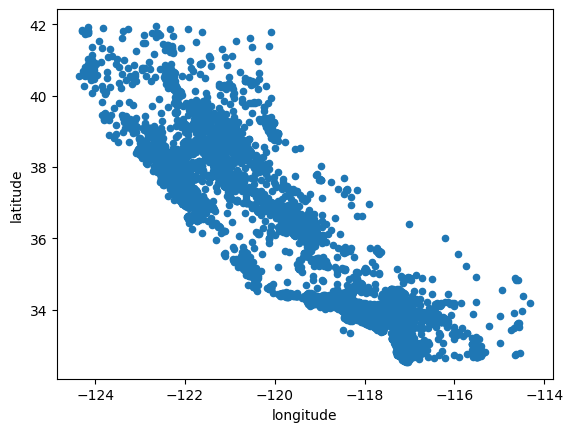

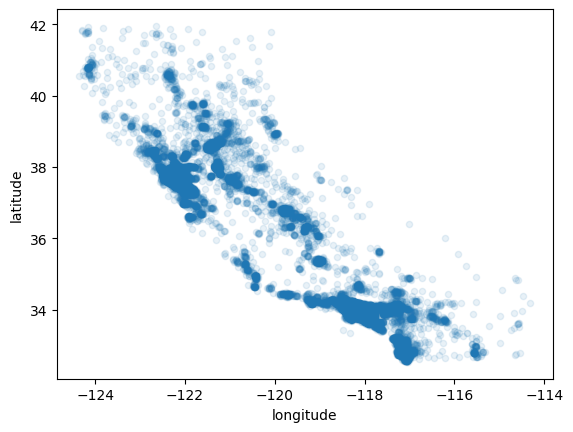

In [10]:
model(housing,strat_train_set,strat_test_set)